In [2]:
import pandas
import altair as alt

In [15]:
short_model_name = "opt-6.7b"
results_filename = f"results/{short_model_name}.csv"
# Read with columns
col_names = ["Mode", "Perplexity"]
df = pandas.read_csv(results_filename, names=col_names, header=None)

base_value = df.loc[df["Mode"] == "fp16"]["Perplexity"].values[0]
df["Diff"] = df["Perplexity"] - base_value
# Format as +/- value with 2 decimal places
df["Diff"] = df["Diff"].map(lambda x: f"{x:+.2f}")

# Remove w4a4 mode
df = df[df["Mode"] != "w4a4"]
df = df[df["Mode"] != "smooth-w4a4"]

# Copilot: Plot perplexity as a function of mode
# The plot is a bar chart with the perplexity values for each mode
# For each bar, label the top with the diff from the base value
# The base value is the value for the mode "fp16"
chart = alt.Chart(df).encode(
    x="Mode",
    y="Perplexity",
    text="Diff",
).properties(
    title=f"Perplexity vs Mode for {short_model_name}",
    width=alt.Step(80),
)

chart.mark_bar() + chart.mark_text(dy=-10)

alt.LayerChart(...)

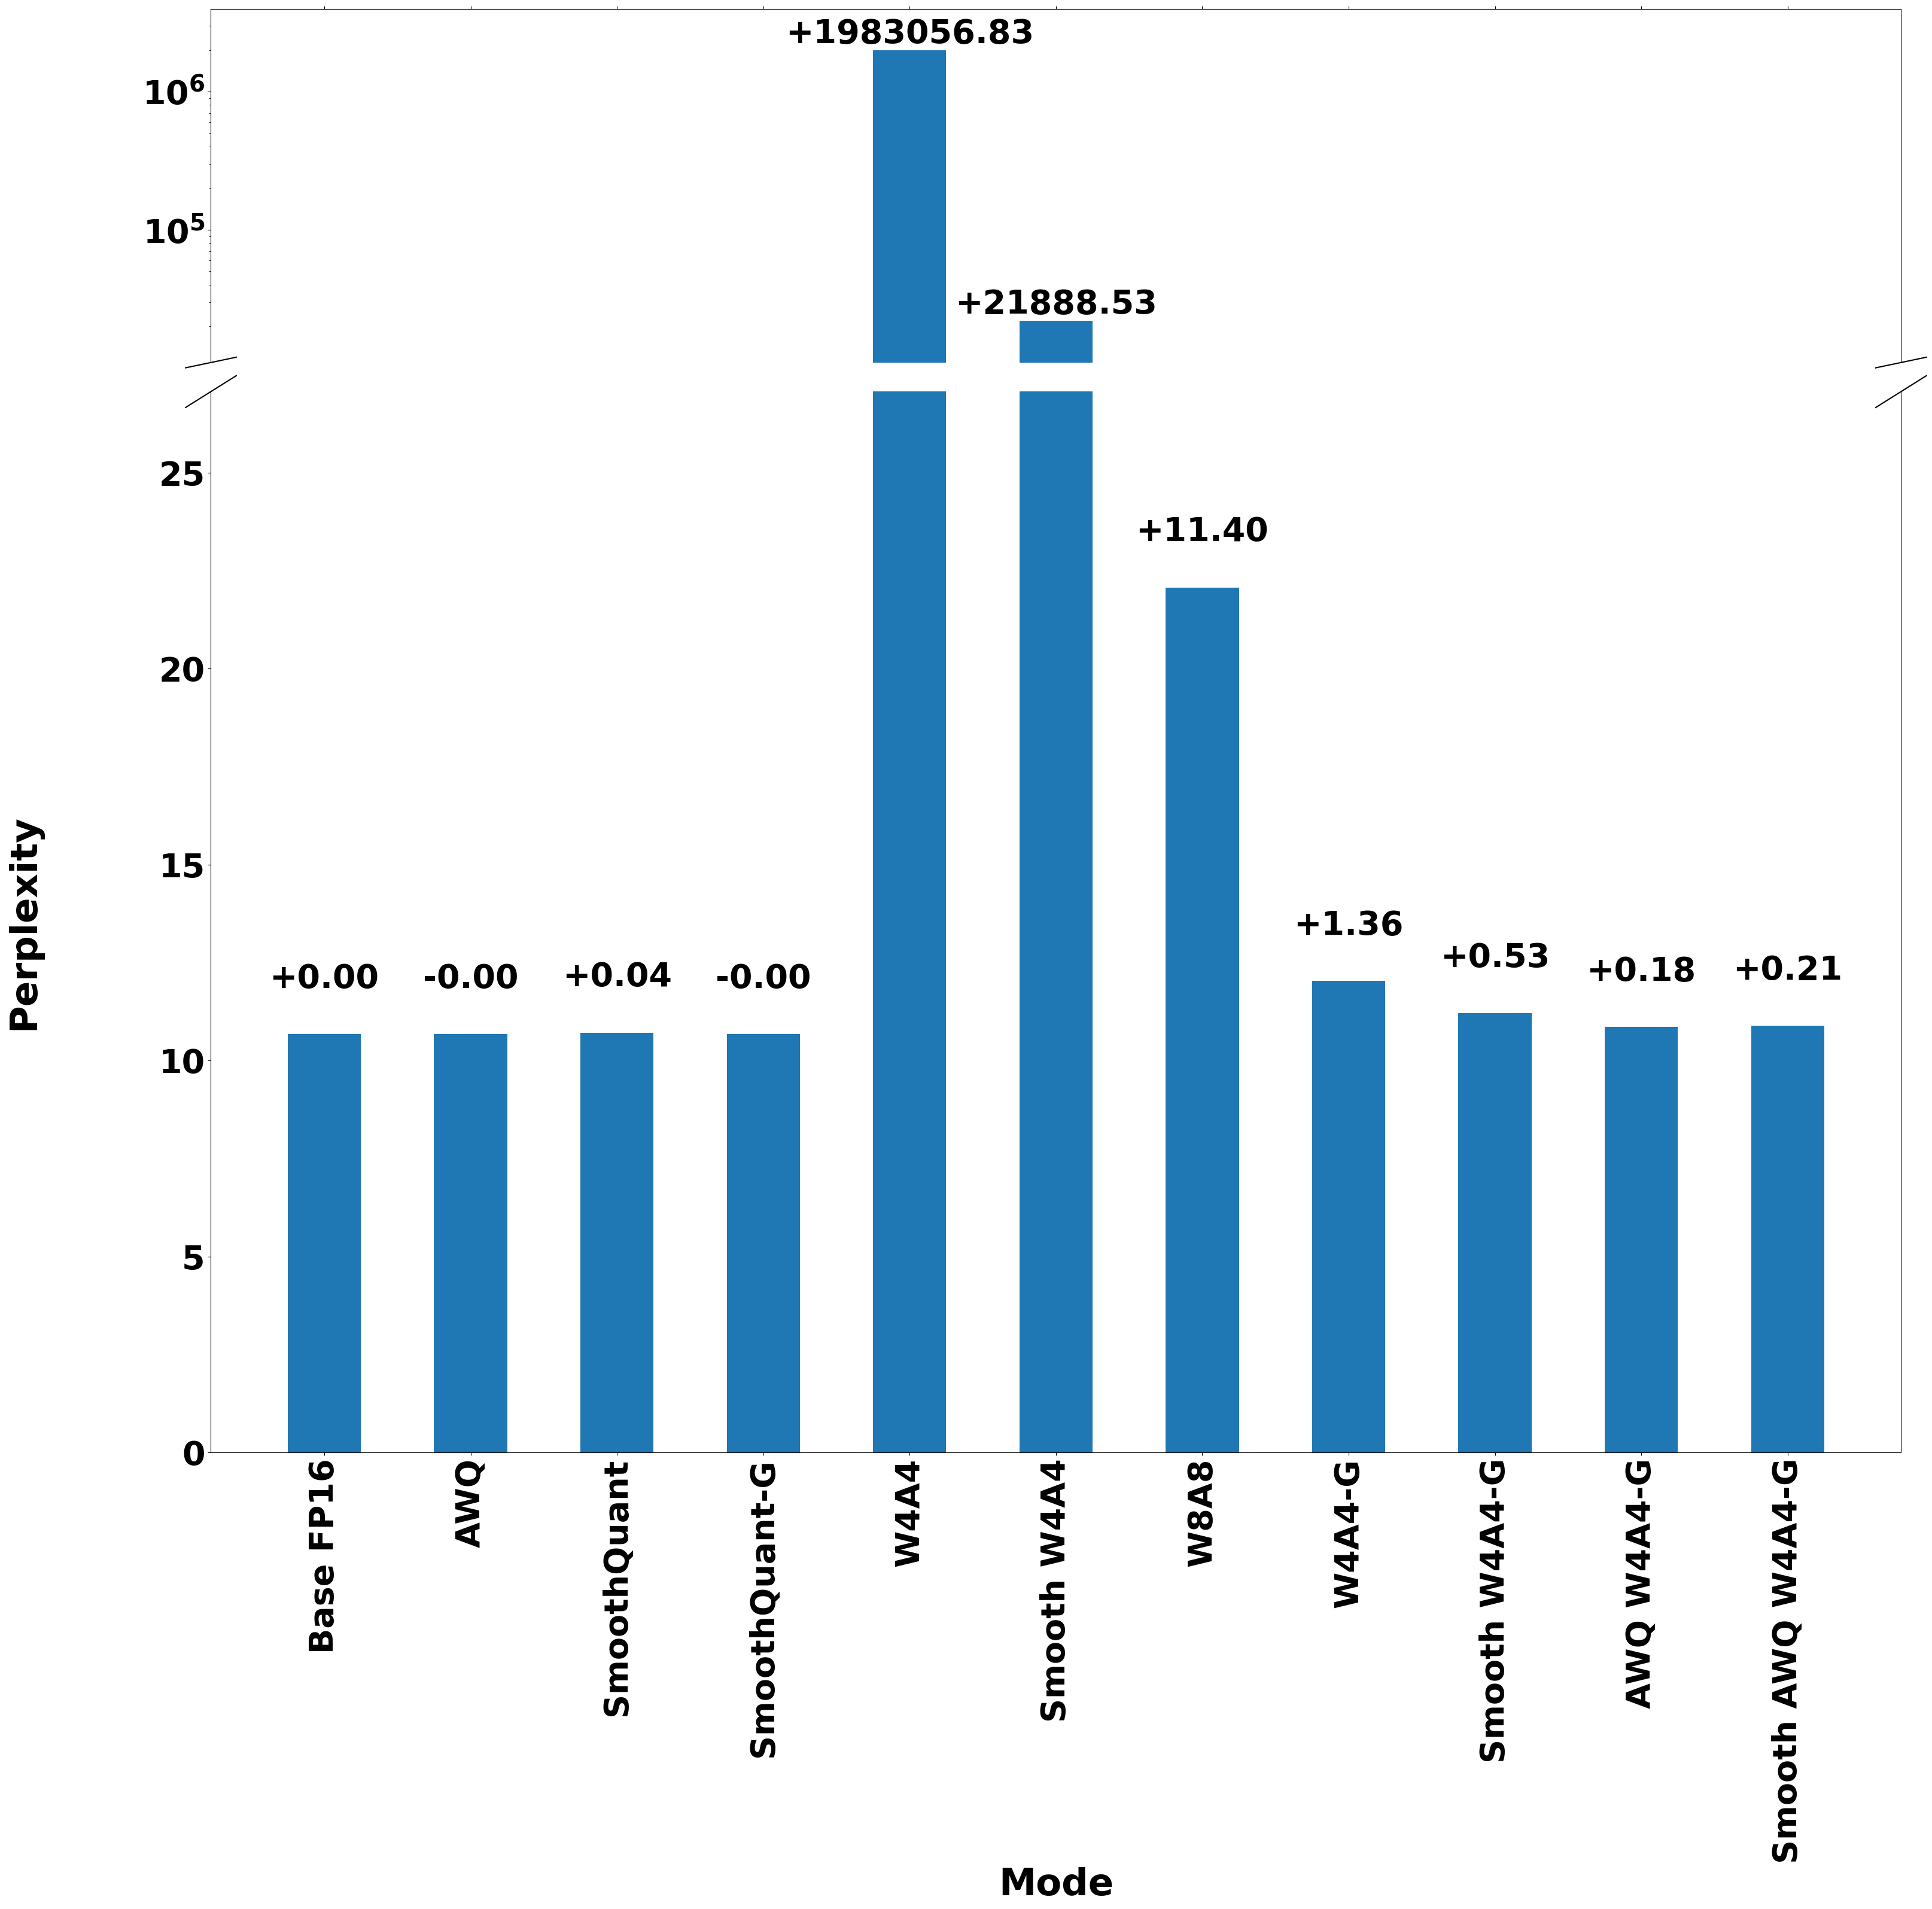

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


short_model_name = "opt-13b"
if short_model_name == "opt-6.7b":
    TN = 2
elif short_model_name == "opt-13b":
    TN = 3
else:
    raise ValueError("Unknown model name")
results_filename = f"results/{short_model_name}.csv"
# Read with columns
col_names = ["Mode", "Perplexity"]
df = pandas.read_csv(results_filename, names=col_names, header=None)

def filter_mode(m):
    if "-Act" in m:
        return False
    return True
    
def rename_mode(m):
    if m == "fp16":
        return "Base FP16"
    if m == "awq":
        return "AWQ"
    if m == "smoothquant":
        return "SmoothQuant"
    if m == "smoothquant-g":
        return "SmoothQuant-G"
    if m == "w4a4":
        return "W4A4"
    if m == "w8a8":
        return "W8A8"
    if m == "smooth-w4a4":
        return "Smooth W4A4"
    m = m.replace("W4A4 G128 AWQ-Mixed-NoAct", "AWQ W4A4-G")
    m = m.replace("W4A4 G128", "W4A4-G")
    return m


base_value = df.loc[df["Mode"] == "fp16"]["Perplexity"].values[0]
df["Diff"] = df["Perplexity"] - base_value
# Format as +/- value with 2 decimal places
df["Diff"] = df["Diff"].map(lambda x: f"{x:+.2f}")

# Make Nicer
df = df[df["Mode"].apply(filter_mode)]
df["Mode"] = df["Mode"].apply(rename_mode)


# Define control variables
PY = -0.1  # Position of the bottom y-axis label
FS_AX = 40  # Font size for axis labels
FW_AX = "bold"  # Font weight for axis labels
FS_T = 45  # Font size for title
FW_T = "bold"  # Font weight for title
color = 'tab:blue'
FIG_W = 32
FIG_H = 32


# Create the plot with axis break
fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 3]}, figsize=(FIG_W, FIG_H))

# Number of values in the upper part
top_values = df.nlargest(TN, 'Perplexity')['Perplexity']
bottom_values = df.nsmallest(len(df) - TN, 'Perplexity')['Perplexity']
upper_min = top_values.min()
upper_max = top_values.max()
lower_max = bottom_values.max()
lower_min = 0



# Upper part (zoomed in on high values). Log scale

ax[0].set_yscale('log')
ax[0].bar(df["Mode"], df["Perplexity"], color=color, width=0.5)
ax[0].set_ylim(upper_min/2, 2*upper_max)
ax[0].spines['bottom'].set_visible(False)
ax[0].xaxis.tick_top()
ax[0].tick_params(labeltop=False, labelsize=FS_AX)

# Lower part (normal values)
ax[1].bar(df["Mode"], df["Perplexity"], color=color, width=0.5)
ax[1].set_ylim(0, lower_max + 5)
ax[1].spines['top'].set_visible(False)

# Add diagonal lines to indicate the break
d = .015  # size of diagonal lines
kwargs = dict(transform=ax[0].transAxes, color='k', clip_on=False)
ax[0].plot((-d, +d), (-d, +d), **kwargs)        # Top-left diagonal
ax[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

kwargs.update(transform=ax[1].transAxes)  # Switch to bottom axes
ax[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
ax[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

# Annotate bars with "Diff" values
for i, (mode, perplexity, diff) in enumerate(zip(df["Mode"], df["Perplexity"], df["Diff"])):
    ax_to_use = ax[0] if perplexity >= upper_min else ax[1]
    ax_to_use.text(i, perplexity + (10 if perplexity >= upper_min else 1), diff, ha='center', va='bottom', fontsize=FS_AX, weight=FW_AX)



# Rotate
plt.xticks(rotation=90, fontsize=FS_AX, weight=FW_AX)

# Label the axes
ax[1].set_xlabel('Mode', fontsize=FS_T, weight=FW_T)
# ax[0].set_ylabel('Perplexity')
ax[1].set_ylabel('Perplexity', fontsize=FS_T, weight=FW_T)
ax[1].yaxis.set_label_coords(PY, 0.5)
plt.yticks(fontsize=FS_AX, weight=FW_AX)
# Set upper axis fontsize and weight
# Apply font size and weight to y-axis ticks
for axis in [ax[0].yaxis, ax[1].yaxis]:
    axis.set_tick_params(labelsize=FS_AX)
    for label in axis.get_majorticklabels():
        label.set_fontweight(FW_AX)

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot
save_file = f"results/perplexity-{short_model_name}.png"
fig.savefig(save_file, pad_inches=0.1, bbox_inches='tight')

